# Create datasets for models

In [18]:
# Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [19]:
# Load datasets
ratings = pd.read_csv('../raw_data/ml-25m/ratings.csv')
movies = pd.read_csv('../raw_data/ml-25m/movies.csv')
genome_scores = pd.read_csv('../raw_data/ml-25m/genome-scores.csv')

df_rows = {
    'ratings': ratings.shape[0],
    'movies': movies.shape[0],
    'genome_scores': genome_scores.shape[0],
}
print(df_rows)

{'ratings': 25000095, 'movies': 62423, 'genome_scores': 15584448}


## Pre-processing

In [20]:
# Positive rating
ratings['positive_rating'] = ratings['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Timestamps for ratings
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
# ratings['year'] = ratings['timestamp'].dt.year
ratings['year_month'] = ratings['timestamp'].dt.to_period('M')

ratings.head()

,userId,movieId,rating,timestamp,positive_rating,year_month
0,1,296,5.0,2006-05-17 15:34:04,1,2006-05
1,1,306,3.5,2006-05-17 12:26:57,0,2006-05
2,1,307,5.0,2006-05-17 12:27:08,1,2006-05
3,1,665,5.0,2006-05-17 15:13:40,1,2006-05
4,1,899,3.5,2006-05-17 12:21:50,0,2006-05


In [21]:
# Movie premier year
movies['premier_year'] = movies['title'].str.extract(r'\((\d{4})\)')
# Convert to int
movies['premier_year'] = pd.to_numeric(movies['premier_year'], errors='coerce').astype('Int64')
# Note: there are some ratings that were done after the premier year. So this variable is not completely OK.

# Movie genres
movies['genre_list'] = movies['genres'].str.split('|')
movies.drop(columns=['genres'], inplace=True)
# When genre is '(no genres listed)', we set it to an empty list
movies['genre_list'] = movies['genre_list'].apply(lambda x: [] if x == ['(no genres listed)'] else x)
# Count number of genres per movie
movies['num_genres'] = movies['genre_list'].str.len()

# # One hot encode genres
# movies_genres = movies['genre_list'].explode().str.get_dummies().groupby(level=0).sum()
# movies = movies.join(movies_genres)
# del movies_genres

# Create column in movies with the amount of ratings per movie
ratings_per_movie = ratings.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie.rename(columns={'rating': 'num_ratings_original'}, inplace=True)
movies = movies.merge(ratings_per_movie, on='movieId', how='left')

# Create column in movies with the amount of positive ratings per movie
positive_ratings_per_movie = ratings.groupby('movieId')['positive_rating'].sum().reset_index()
positive_ratings_per_movie.rename(columns={'positive_rating': 'num_positive_ratings_original'}, inplace=True)
movies = movies.merge(positive_ratings_per_movie, on='movieId', how='left')

movies.head()

,movieId,title,premier_year,genre_list,num_genres,num_ratings_original,num_positive_ratings_original
0,1,Toy Story (1995),1995,"[Adventure, Animation, Children, Comedy, Fantasy]",5,57309.0,37709.0
1,2,Jumanji (1995),1995,"[Adventure, Children, Fantasy]",3,24228.0,8276.0
2,3,Grumpier Old Men (1995),1995,"[Comedy, Romance]",2,11804.0,3674.0
3,4,Waiting to Exhale (1995),1995,"[Comedy, Drama, Romance]",3,2523.0,637.0
4,5,Father of the Bride Part II (1995),1995,[Comedy],1,11714.0,3161.0


## Subsetting

In [22]:
ratings_subset = ratings.copy()
movies_subset = movies.copy()
genome_scores_subset = genome_scores.copy()

### Users-Ratings
The users in the dataset have 20 ratings or more.

There are not duplicated user-ratings pairs.

In [23]:
# Only keep users that made at least 10 positive ratings
users_positive_rating_count = ratings.groupby('userId')['positive_rating'].sum()
users_at_least_10_positive_ratings = users_positive_rating_count[users_positive_rating_count >= 10].index.tolist()

# Subset
ratings_subset = ratings_subset[ratings_subset['userId'].isin(users_at_least_10_positive_ratings)]

print("Number of ratings before filtering: ", df_rows['ratings'])
print("Number of ratings after filtering: ", ratings_subset.shape[0])
print("Rows lost: ", df_rows['ratings'] - ratings_subset.shape[0], "(", round((df_rows['ratings'] - ratings_subset.shape[0]) / df_rows['ratings'] * 100, 2), "%)")
df_rows['ratings'] = ratings_subset.shape[0]

Number of ratings before filtering:  25000095
Number of ratings after filtering:  24751207
Rows lost:  248888 ( 1.0 %)


In [24]:
# Decrease ratings from users with too many ratings

# Count the amount of ratings per user
ratings_per_user = ratings_subset.groupby('userId').size().reset_index(name='count')

# Get the users with more than 500 ratings
very_active_users = ratings_per_user[ratings_per_user['count'] > 500]['userId']

# Remove very active users (temporarily)
ratings_subset_very_active_users = ratings_subset[ratings_subset['userId'].isin(very_active_users)]
ratings_subset = ratings_subset[~ratings_subset['userId'].isin(very_active_users)]

# For those users, only keep the first 500 ratings
ratings_subset_very_active_users = ratings_subset_very_active_users.sort_values(by=['userId', 'timestamp']).reset_index(drop=True)
ratings_subset_very_active_users = ratings_subset_very_active_users.groupby('userId').head(500).reset_index(drop=True)

# Merge the two dataframes
ratings_subset = pd.concat([ratings_subset, ratings_subset_very_active_users], ignore_index=True)
# del ratings_subset_very_active_users

print("Number of ratings before filtering: ", df_rows['ratings'])
print("Number of ratings after filtering: ", ratings_subset.shape[0])
print("Rows lost: ", df_rows['ratings'] - ratings_subset.shape[0], "(", round((df_rows['ratings'] - ratings_subset.shape[0]) / df_rows['ratings'] * 100, 2), "%)")
df_rows['ratings'] = ratings_subset.shape[0]

Number of ratings before filtering:  24751207
Number of ratings after filtering:  20651868
Rows lost:  4099339 ( 16.56 %)


### Movies

In [25]:
# At least 1 genre
one_genre = movies['num_genres'] > 0

# At least 20 ratings
ratings_per_movie = ratings_subset.groupby('movieId').size().reset_index(name='count')
movies_at_least_20_ratings = ratings_per_movie[ratings_per_movie['count'] >= 20]['movieId']
at_least_20_ratings = movies['movieId'].isin(movies_at_least_20_ratings)

# At least 5 positive ratings
positive_ratings_per_movie = ratings_subset[ratings_subset['positive_rating']>0].groupby('movieId').size().reset_index(name='count')
movies_at_least_5_positive_ratings = positive_ratings_per_movie[positive_ratings_per_movie['count'] >= 5]['movieId']
at_least_5_positive_ratings = movies['movieId'].isin(movies_at_least_5_positive_ratings)

# Premier year not missing
premier_year_notna = movies['premier_year'].notna()

# Subset
movies_subset = movies[one_genre & at_least_20_ratings & at_least_5_positive_ratings & premier_year_notna]
print("Number of movies before filtering: ", df_rows['movies'])
print("Number of movies after filtering: ", movies_subset.shape[0])
print("Rows lost: ", df_rows['movies'] - movies_subset.shape[0], "(", round((df_rows['movies'] - movies_subset.shape[0]) / df_rows['movies'] * 100, 2), "%)")
df_rows['movies'] = movies_subset.shape[0]

Number of movies before filtering:  62423
Number of movies after filtering:  13183
Rows lost:  49240 ( 78.88 %)


### Re-process ratings

In [26]:
# Keep ratings for the movies in the subset
ratings_subset = ratings_subset[ratings_subset['movieId'].isin(movies_subset['movieId'])]

print("Number of ratings before filtering: ", df_rows['ratings'])
print("Number of ratings after filtering: ", ratings_subset.shape[0])
print("Rows lost: ", df_rows['ratings'] - ratings_subset.shape[0], "(", round((df_rows['ratings'] - ratings_subset.shape[0]) / df_rows['ratings'] * 100, 2), "%)")
df_rows['ratings'] = ratings_subset.shape[0]

Number of ratings before filtering:  20651868
Number of ratings after filtering:  20521832
Rows lost:  130036 ( 0.63 %)


In [27]:
# # Create column in movies with the amount of ratings per movie
# ratings_per_movie_subset = ratings_subset.groupby('movieId')['rating'].count().reset_index()
# ratings_per_movie_subset.rename(columns={'rating': 'num_ratings_subset1'}, inplace=True)
# movies_subset = movies_subset.merge(ratings_per_movie_subset, on='movieId', how='left')

# movies_subset.head()

### Genome scores

In [28]:
# Only keep scores for movies in the subset
genome_scores_subset = genome_scores[genome_scores['movieId'].isin(movies_subset['movieId'])]

print("Number of genome scores before filtering: ", df_rows['genome_scores'])
print("Number of genome scores after filtering: ", genome_scores_subset.shape[0])
print("Rows lost: ", df_rows['genome_scores'] - genome_scores_subset.shape[0], "(", round((df_rows['genome_scores'] - genome_scores_subset.shape[0]) / df_rows['genome_scores'] * 100, 2), "%)")
df_rows['genome_scores'] = genome_scores_subset.shape[0]

Number of genome scores before filtering:  15584448
Number of genome scores after filtering:  14421480
Rows lost:  1162968 ( 7.46 %)


## Train-validation-test split

In [29]:
# Find out which dates are the best to split the data into train, test and validation sets

# Sort once by chronological order
ratings_chrono = ratings_subset[['timestamp']].sort_values('timestamp').reset_index(drop=True)

# Select an initial date for the split
# t_train_starts = ratings_chrono.loc[0, 'timestamp']
t_train_starts = pd.to_datetime('2014-01-01 00:00:00')
print("Training set starts: ", t_train_starts)

# Subset the data
old_rows = ratings_chrono.shape[0]
ratings_chrono = ratings_chrono[ratings_chrono['timestamp'] >= t_train_starts].reset_index(drop=True)
print("Number of ratings before filtering: ", old_rows)
print("Number of ratings after filtering: ", ratings_chrono.shape[0])
print("Rows lost: ", old_rows - ratings_chrono.shape[0], "(", round((old_rows - ratings_chrono.shape[0]) / old_rows * 100, 2), "%)")

# Compute index cut‑offs that correspond to 70 % and 80 %
n_total     = len(ratings_chrono)
idx_train   = int(n_total * 0.70)
idx_val    = int(n_total * 0.80)

# Determine the *exact* wall‑clock cut‑off timestamps
t_val_starts = ratings_chrono.loc[idx_train, 'timestamp']
t_test_starts  = ratings_chrono.loc[idx_val,  'timestamp']
t_test_end  = ratings_chrono.loc[n_total-1, 'timestamp']
print("Train end: ", t_val_starts)
print("Validation end: ", t_test_starts)
print("Test end: ", t_test_end)
del ratings_chrono

Training set starts:  2014-01-01 00:00:00
Number of ratings before filtering:  20521832
Number of ratings after filtering:  6141446
Rows lost:  14380386 ( 70.07 %)
Train end:  2017-12-26 19:21:33
Validation end:  2018-08-25 23:59:04
Test end:  2019-11-21 09:15:03


In [30]:
# Determine final cut-off timestamps
# t_val_starts = pd.to_datetime('2014-01-01 00:00:00')
# t_test_starts = pd.to_datetime('2016-01-01 00:00:00')
t_train_starts = pd.to_datetime('2015-01-01 00:00:00')
t_val_starts = pd.to_datetime('2017-01-01 00:00:00')
t_test_starts = pd.to_datetime('2018-01-01 00:00:00')

print("Train start: ", t_train_starts)
print("Train end: ", t_val_starts)
print("Validation end: ", t_test_starts)
print("Test end: ", t_test_end)

Train start:  2015-01-01 00:00:00
Train end:  2017-01-01 00:00:00
Validation end:  2018-01-01 00:00:00
Test end:  2019-11-21 09:15:03


In [31]:
# Slice DataFrames into train, test and validation sets
train_mask = (ratings_subset['timestamp'] >= t_train_starts) & (ratings_subset['timestamp'] < t_val_starts)
test_mask  = (ratings_subset['timestamp'] >= t_val_starts) & (ratings_subset['timestamp'] < t_test_starts)
val_mask   = ratings_subset['timestamp'] >= t_test_starts

ratings_train = ratings_subset.loc[train_mask].copy()
ratings_test  = ratings_subset.loc[test_mask ].copy()
ratings_val   = ratings_subset.loc[val_mask  ].copy()


# Sanity check
pcts = {}
for name, df in zip(['Train', 'Validation', 'Test'],
                    [ratings_train, ratings_test, ratings_val]):
    pcts[name] = round((len(df) / n_total)*100)
    
    print(f"{name:11} → {len(df):,} rows   ({pcts[name]})")

Train       → 2,672,720 rows   (44)
Validation  → 1,272,298 rows   (21)
Test        → 1,823,353 rows   (30)


### Processing after split

#### Ratings

We will not allow users without ratings in the training set (no cold start problem for users). In a real application, this would mean that, in a real application, we would have to ask users to select X movies they liked in order to start recommending.

In [32]:
# Keep ratings from users that made at least 1 positive ratings in the training set
users_positive_rating_count_train = ratings_train.groupby('userId')['positive_rating'].sum()
users_at_least_x_positive_rating_train = users_positive_rating_count_train[users_positive_rating_count_train >= 1].index.tolist()

# Subset training
old_rows = ratings_train.shape[0]
print("Number of (training) ratings before filtering: ", ratings_train.shape[0])
ratings_train = ratings_train[ratings_train['userId'].isin(users_at_least_x_positive_rating_train)]
print("Number of (training) ratings after filtering: ", ratings_train.shape[0])
print("Rows lost: ", old_rows - ratings_train.shape[0], "(", round((old_rows - ratings_train.shape[0]) / old_rows * 100, 2), "%)")
print("Amount of remaining users: ", ratings_train['userId'].nunique())
print("\n")

# Subset validation
old_rows = ratings_val.shape[0]
print("Number of (validation) ratings before filtering: ", ratings_val.shape[0])
ratings_val = ratings_val[ratings_val['userId'].isin(users_at_least_x_positive_rating_train)]
print("Number of (test) ratings after filtering: ", ratings_val.shape[0])
print("Rows lost: ", old_rows - ratings_val.shape[0], "(", round((old_rows - ratings_val.shape[0]) / old_rows * 100, 2), "%)")
print("Amount of remaining users: ", ratings_val['userId'].nunique())
print("\n")

# Keep ratings in test from users that made at least 1 positive ratings in the training or validation sets
users_positive_rating_count_val = ratings_val.groupby('userId')['positive_rating'].sum()
users_at_least_x_positive_rating_val = users_positive_rating_count_val[users_positive_rating_count_val >= 1].index.tolist()
users_at_least_x_positive_rating_train_val = set(users_at_least_x_positive_rating_train).union(set(users_at_least_x_positive_rating_val))

# Subset test
old_rows = ratings_test.shape[0]
print("Number of (test) ratings before filtering: ", ratings_test.shape[0])
ratings_test = ratings_test[ratings_test['userId'].isin(users_at_least_x_positive_rating_train_val)]
print("Number of (test) ratings after filtering: ", ratings_test.shape[0])
print("Rows lost: ", old_rows - ratings_test.shape[0], "(", round((old_rows - ratings_test.shape[0]) / old_rows * 100, 2), "%)")
print("Amount of remaining users: ", ratings_test['userId'].nunique())
print("\n")

Number of (training) ratings before filtering:  2672720
Number of (training) ratings after filtering:  2672560
Rows lost:  160 ( 0.01 %)
Amount of remaining users:  22662


Number of (validation) ratings before filtering:  1823353
Number of (test) ratings after filtering:  101233
Rows lost:  1722120 ( 94.45 %)
Amount of remaining users:  2613


Number of (test) ratings before filtering:  1272298
Number of (test) ratings after filtering:  118923
Rows lost:  1153375 ( 90.65 %)
Amount of remaining users:  3084




In [33]:
# Keep ratings from users that made at least 5 positive ratings in the validation set
users_positive_rating_count_val = ratings_val.groupby('userId')['positive_rating'].sum()
users_at_least_5_positive_rating_val = users_positive_rating_count_val[users_positive_rating_count_val >= 5].index.tolist()

# Subset
old_rows = ratings_val.shape[0]
print("Number of ratings before filtering: ", ratings_val.shape[0])
ratings_val = ratings_val[ratings_val['userId'].isin(users_at_least_5_positive_rating_val)]

print("Number of ratings after filtering: ", ratings_val.shape[0])
print("Rows lost: ", old_rows - ratings_val.shape[0], "(", round((old_rows - ratings_val.shape[0]) / old_rows * 100, 2), "%)")

Number of ratings before filtering:  101233
Number of ratings after filtering:  96799
Rows lost:  4434 ( 4.38 %)


In [34]:
# Keep ratings from users that made at least 5 positive ratings in the test set
users_positive_rating_count_test = ratings_test.groupby('userId')['positive_rating'].sum()
users_at_least_5_positive_rating_test = users_positive_rating_count_test[users_positive_rating_count_test >= 5].index.tolist()

# Subset
old_rows = ratings_test.shape[0]
print("Number of ratings before filtering: ", ratings_test.shape[0])
ratings_test = ratings_test[ratings_test['userId'].isin(users_at_least_5_positive_rating_test)]

print("Number of ratings after filtering: ", ratings_test.shape[0])
print("Rows lost: ", old_rows - ratings_test.shape[0], "(", round((old_rows - ratings_test.shape[0]) / old_rows * 100, 2), "%)")

Number of ratings before filtering:  118923
Number of ratings after filtering:  112899
Rows lost:  6024 ( 5.07 %)


#### Movies

We will allow movies without ratings in the training set. We will device a way to solve this "cold start" problem.

In [35]:
# Flag movies in the validation and test sets that are not in the training set
movies_subset['in_train'] = movies_subset['movieId'].isin(ratings_train['movieId'])
movies_subset['in_val'] = movies_subset['movieId'].isin(ratings_val['movieId'])
movies_subset['in_test'] = movies_subset['movieId'].isin(ratings_test['movieId'])

# Report
print("There are", len(movies_subset), "movies in the entire remaining data.")
print("\n")

n_movies_in_train = movies_subset['in_train'].sum()
n_movies_in_val = movies_subset['in_val'].sum()
n_movies_in_train_or_val = (movies_subset['in_train'] | movies_subset['in_val']).sum()
n_movies_in_test = movies_subset['in_test'].sum()

print(f"There are {n_movies_in_train} ({round(n_movies_in_train/len(movies_subset)*100)}%) movies in the training set")
print(f"There are {n_movies_in_val} ({round(n_movies_in_val/len(movies_subset)*100)}%) movies in the validation set")
print(f"There are {n_movies_in_train_or_val} ({round(n_movies_in_train_or_val/len(movies_subset)*100)}%) movies in the training and validation sets")
print(f"There are {n_movies_in_test} ({round(n_movies_in_test/len(movies_subset)*100)}%) movies in the test set")
print("\n")

movies_val_not_in_train = n_movies_in_val - n_movies_in_train
movies_test_not_in_train = n_movies_in_test - n_movies_in_train
movies_test_not_in_train_or_val = max(n_movies_in_test - n_movies_in_train_or_val, 0)
print(f"There are {movies_val_not_in_train} ({round(movies_val_not_in_train/len(movies_subset)*100)}%) movies in the validation set that are not in the training set")
print(f"There are {movies_test_not_in_train} ({round(movies_test_not_in_train/len(movies_subset)*100)}%) movies in the test set that are not in the training set")
print(f"There are {movies_test_not_in_train_or_val} ({round(movies_test_not_in_train_or_val/len(movies_subset)*100)}%) movies in the test set that are not in the training and validation sets")
print("\n")

There are 13183 movies in the entire remaining data.


There are 11854 (90%) movies in the training set
There are 7792 (59%) movies in the validation set
There are 12498 (95%) movies in the training and validation sets
There are 7828 (59%) movies in the test set


There are -4062 (-31%) movies in the validation set that are not in the training set
There are -4026 (-31%) movies in the test set that are not in the training set
There are 0 (0%) movies in the test set that are not in the training and validation sets




C:\Users\Usuario\AppData\Local\Temp\ipykernel_1980\2843114191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_subset['in_train'] = movies_subset['movieId'].isin(ratings_train['movieId'])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_1980\2843114191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_subset['in_val'] = movies_subset['movieId'].isin(ratings_val['movieId'])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_1980\2843114191.py:4: SettingWithCopyWarning: 
A value is trying to be set

Add columns with ratings counts

In [36]:
# Create column in movies with the amount of ratings per movie
ratings_per_movie_train = ratings_train.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie_train.rename(columns={'rating': 'num_ratings_train'}, inplace=True)
movies_subset = movies_subset.merge(ratings_per_movie_train, on='movieId', how='left')

ratings_per_movie_val = ratings_val.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie_val.rename(columns={'rating': 'num_ratings_val'}, inplace=True)
movies_subset = movies_subset.merge(ratings_per_movie_val, on='movieId', how='left')

ratings_per_movie_test = ratings_test.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie_test.rename(columns={'rating': 'num_ratings_test'}, inplace=True)
movies_subset = movies_subset.merge(ratings_per_movie_test, on='movieId', how='left')

# Create column in movies with the amount of positive ratings per movie
positive_ratings_per_movie_train = ratings_train.groupby('movieId')['positive_rating'].sum().reset_index()
positive_ratings_per_movie_train.rename(columns={'positive_rating': 'num_positive_ratings_train'}, inplace=True)
movies_subset = movies_subset.merge(positive_ratings_per_movie_train, on='movieId', how='left')

positive_ratings_per_movie_val = ratings_val.groupby('movieId')['positive_rating'].sum().reset_index()
positive_ratings_per_movie_val.rename(columns={'positive_rating': 'num_positive_ratings_val'}, inplace=True)
movies_subset = movies_subset.merge(positive_ratings_per_movie_val, on='movieId', how='left')

positive_ratings_per_movie_test = ratings_test.groupby('movieId')['positive_rating'].sum().reset_index()
positive_ratings_per_movie_test.rename(columns={'positive_rating': 'num_positive_ratings_test'}, inplace=True)
movies_subset = movies_subset.merge(positive_ratings_per_movie_test, on='movieId', how='left')

movies_subset.head()

,movieId,title,premier_year,genre_list,num_genres,num_ratings_original,num_positive_ratings_original,in_train,in_val,in_test,num_ratings_train,num_ratings_val,num_ratings_test,num_positive_ratings_train,num_positive_ratings_val,num_positive_ratings_test
0,1,Toy Story (1995),1995,"[Adventure, Animation, Children, Comedy, Fantasy]",5,57309.0,37709.0,True,True,True,7411.0,93.0,117.0,4454.0,47.0,73.0
1,2,Jumanji (1995),1995,"[Adventure, Children, Fantasy]",3,24228.0,8276.0,True,True,True,1885.0,62.0,73.0,721.0,31.0,33.0
2,3,Grumpier Old Men (1995),1995,"[Comedy, Romance]",2,11804.0,3674.0,True,True,True,169.0,2.0,2.0,42.0,1.0,1.0
3,4,Waiting to Exhale (1995),1995,"[Comedy, Drama, Romance]",3,2523.0,637.0,True,False,False,34.0,NaN,NaN,13.0,NaN,NaN
4,5,Father of the Bride Part II (1995),1995,[Comedy],1,11714.0,3161.0,True,True,True,383.0,6.0,8.0,110.0,1.0,2.0


#### Cold-start movies

As there are no movies in the test set that do not have a rating in the training or validation sets, we will try to look for them in the original data.

In [37]:
# Separate the ratings in the validation set that are not in the training set
if movies_val_not_in_train > 0:
    ratings_val_not_in_train = ratings_val[ratings_val['movieId'].isin(movies_subset[movies_subset['in_val'] & ~movies_subset['in_train']]['movieId'])].copy()
    ratings_val = ratings_val[~ratings_val['movieId'].isin(ratings_val_not_in_train['movieId'])].copy()

    print("Number of ratings in the validation set that are not in the training set: ", ratings_val_not_in_train.shape[0])
    print("Number of ratings in the validation set after filtering: ", ratings_val.shape[0])

There are no movies that are rated in the test set, but do not have any ratings in the training and validation sets

In [38]:
# Get the movies (from the original dataframe) that do not have a rating in the training set or the validation set
movie_ids_in_train = movies_subset[movies_subset['in_train']]['movieId'].tolist()
movie_ids_in_val = movies_subset[movies_subset['in_val']]['movieId'].tolist()

movies_not_in_train_or_val = movies[(~movies['movieId'].isin(movie_ids_in_train)) & (~movies['movieId'].isin(movie_ids_in_val))]

# Subset to movies that were premiered after the validation set cut-off date
movies_not_in_train_or_val = movies_not_in_train_or_val[movies_not_in_train_or_val['premier_year'] >= t_test_starts.year]

# For each movie in the ratings data, get the first rating
first_ratings = ratings.groupby('movieId')['timestamp'].min().reset_index()
first_ratings.rename(columns={'timestamp': 'first_rating_date'}, inplace=True)

# Merge with the movies dataframe
movies_not_in_train_or_val = movies_not_in_train_or_val.merge(first_ratings, on='movieId', how='left')

# Subset to movies that were first rated after the validation set cut-off date
movies_not_in_train_or_val = movies_not_in_train_or_val[movies_not_in_train_or_val['first_rating_date'] >= t_test_starts]
movies_not_in_train_or_val.drop(columns=['first_rating_date'], inplace=True)

# Of these movies, only keep those that were rated by users who are present in the training or validation set
ratings_movies_not_in_train_or_val = ratings[ratings['movieId'].isin(movies_not_in_train_or_val['movieId'])]
users_ids_movies_not_in_train_or_val = ratings_movies_not_in_train_or_val['userId'].unique().tolist()
users_ids_in_train_or_val = set(ratings_train['userId'].tolist()).union(set(ratings_val['userId'].tolist()))
those_users_in_train_or_val = set(users_ids_movies_not_in_train_or_val).intersection(users_ids_in_train_or_val)
ratings_by_those_users = ratings_movies_not_in_train_or_val[ratings_movies_not_in_train_or_val['userId'].isin(those_users_in_train_or_val)]
movies_to_keep = ratings_by_those_users['movieId'].unique().tolist()

movies_not_in_train_or_val = movies_not_in_train_or_val[movies_not_in_train_or_val['movieId'].isin(movies_to_keep)]

# At least 1 genre
one_genre = movies_not_in_train_or_val['num_genres'] > 0
movies_not_in_train_or_val = movies_not_in_train_or_val[one_genre]

# Premier year not missing
premier_year_notna = movies['premier_year'].notna()
movies_not_in_train_or_val = movies_not_in_train_or_val[premier_year_notna]

# Now get the ratings from those movies
ratings_not_in_train_or_val = ratings[ratings['movieId'].isin(movies_not_in_train_or_val['movieId'])].copy()

# Make sure they were done after the validation set cut-off date
ratings_not_in_train_or_val = ratings_not_in_train_or_val[ratings_not_in_train_or_val['timestamp'] >= t_test_starts]

# At least 20 ratings
ratings_per_movie = ratings_not_in_train_or_val.groupby('movieId').size().reset_index(name='count')
movies_at_least_20_ratings = ratings_per_movie[ratings_per_movie['count'] >= 20]['movieId']
at_least_20_ratings = movies_not_in_train_or_val['movieId'].isin(movies_at_least_20_ratings)
movies_not_in_train_or_val = movies_not_in_train_or_val[at_least_20_ratings]

# At least 5 positive ratings
positive_ratings_per_movie = ratings_not_in_train_or_val[ratings_not_in_train_or_val['positive_rating']>0].groupby('movieId').size().reset_index(name='count')
movies_at_least_5_positive_ratings = positive_ratings_per_movie[positive_ratings_per_movie['count'] >= 5]['movieId']
at_least_5_positive_ratings = movies_not_in_train_or_val['movieId'].isin(movies_at_least_5_positive_ratings)
movies_not_in_train_or_val = movies_not_in_train_or_val[at_least_5_positive_ratings]

print("Cold start test movies: ", len(movies_not_in_train_or_val))
print("Associated ratings: ", len(ratings_not_in_train_or_val))
print("Associated positive ratings: ", len(ratings_not_in_train_or_val[ratings_not_in_train_or_val['positive_rating'] > 0]))
movies_not_in_train_or_val.head()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_1980\1776437126.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_not_in_train_or_val = movies_not_in_train_or_val[premier_year_notna]


Cold start test movies:  213
Associated ratings:  18503
Associated positive ratings:  5012


,movieId,title,premier_year,genre_list,num_genres,num_ratings_original,num_positive_ratings_original
2,182369,Journey's End (2018),2018,[War],1,24.0,7.0
3,182835,The 15:17 to Paris (2018),2018,"[Drama, Thriller]",2,73.0,5.0
4,183055,The Beyond (2018),2018,"[Horror, Sci-Fi]",2,39.0,7.0
8,183353,Proud Mary (2018),2018,"[Action, Thriller]",2,40.0,5.0
10,183419,Acts of Violence (2018),2018,[Action],1,31.0,5.0


### Plot

In [39]:
# ### Plot – monthly volume coming from the three splits

# Count ratings per month in each split
train_by_month = (ratings_train     ['timestamp']
                  .dt.to_period('M')
                  .value_counts()
                  .sort_index())

val_by_month   = (ratings_val       ['timestamp']
                  .dt.to_period('M')
                  .value_counts()
                  .sort_index())

test_by_month  = (ratings_test      ['timestamp']
                  .dt.to_period('M')
                  .value_counts()
                  .sort_index())

# Combine them.  (Index is a PeriodIndex, so '+' aligns by month.)
ratings_by_month = (train_by_month
                    .add(val_by_month,  fill_value=0)
                    .add(test_by_month, fill_value=0)
                    .astype(int)           # back to int for nicer ticks
                    .sort_index())

In [40]:
# Count unique users per month in each split
train_users_by_month = (ratings_train
                        .groupby(ratings_train['timestamp'].dt.to_period('M'))['userId']
                        .nunique()
                        .sort_index())

val_users_by_month = (ratings_val
                      .groupby(ratings_val['timestamp'].dt.to_period('M'))['userId']
                      .nunique()
                      .sort_index())

test_users_by_month = (ratings_test
                       .groupby(ratings_test['timestamp'].dt.to_period('M'))['userId']
                       .nunique()
                       .sort_index())

# Combine them (align by PeriodIndex)
users_by_month = (train_users_by_month
                  .add(val_users_by_month, fill_value=0)
                  .add(test_users_by_month, fill_value=0)
                  .astype(int)
                  .sort_index())

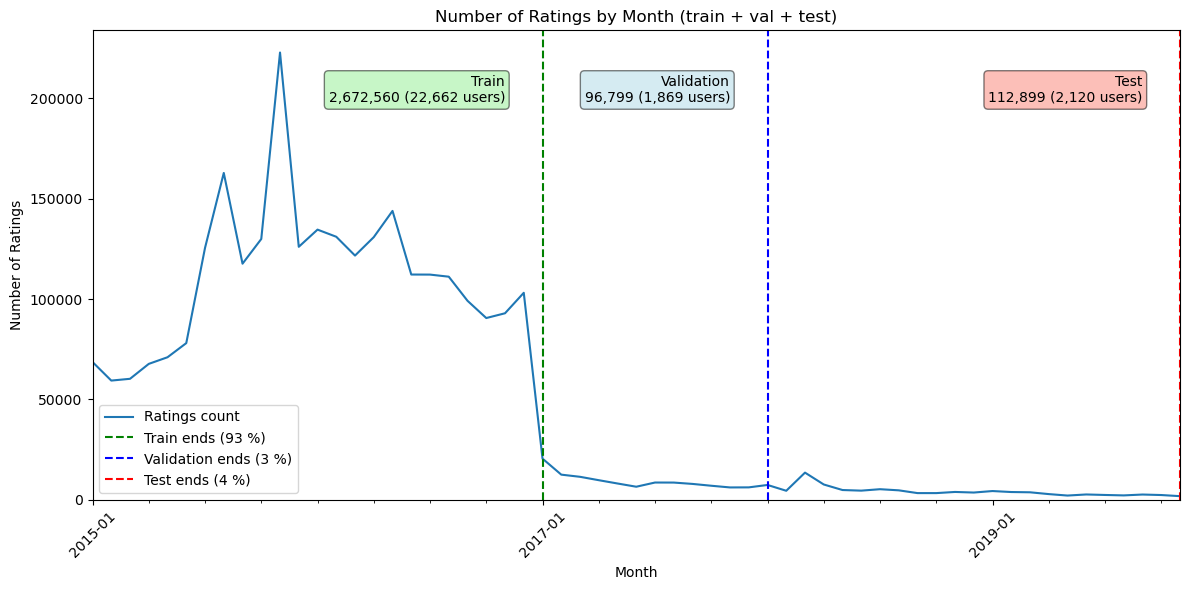

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
ratings_by_month.plot(kind='line', label='Ratings count')

plt.title('Number of Ratings by Month (train + val + test)')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')

# Compute percentages and counts for the legend and boxes
n_total = len(ratings_train) + len(ratings_val) + len(ratings_test)
counts = {'Train': len(ratings_train),
          'Validation': len(ratings_val),
          'Test': len(ratings_test)}
pcts = {k: round(v / n_total * 100) for k, v in counts.items()}

user_counts = {
    'Train': ratings_train['userId'].nunique(),
    'Validation': ratings_val['userId'].nunique(),
    'Test': ratings_test['userId'].nunique()
}


# Vertical lines at split cut‑offs
plt.axvline(x=t_val_starts, color='g', linestyle='--',
            label=f'Train ends ({pcts["Train"]} %)')
plt.axvline(x=t_test_starts,   color='b', linestyle='--',
            label=f'Validation ends ({pcts["Validation"]} %)')
plt.axvline(x=t_test_end,  color='r', linestyle='--',
            label=f'Test ends ({pcts["Test"]} %)')

# Determine vertical position for text boxes
y_max = ratings_by_month.max()
y_pos = y_max * 0.95  # vertical position (5% below max)

# Convert Period to Timestamp if needed
t_val_starts_ts = t_val_starts.to_timestamp() if hasattr(t_val_starts, 'to_timestamp') else t_val_starts
t_test_starts_ts   = t_test_starts.to_timestamp()   if hasattr(t_test_starts, 'to_timestamp')   else t_test_starts
t_test_end_ts  = t_test_end.to_timestamp()  if hasattr(t_test_end, 'to_timestamp')  else t_test_end

# Add text boxes shifted 2 months to the left
plt.text(t_val_starts_ts - pd.DateOffset(months=2), y_pos,
         f'Train\n{counts["Train"]:,} ({user_counts["Train"]:,} users)',
         ha='right', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.text(t_test_starts_ts - pd.DateOffset(months=2), y_pos,
         f'Validation\n{counts["Validation"]:,} ({user_counts["Validation"]:,} users)',
         ha='right', va='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.text(t_test_end_ts - pd.DateOffset(months=2), y_pos,
         f'Test\n{counts["Test"]:,} ({user_counts["Test"]:,} users)',
         ha='right', va='top', bbox=dict(boxstyle='round', facecolor='salmon', alpha=0.5))

plt.legend()

# Show an x‑tick every two years
plt.xticks(ticks=ratings_by_month.index[::24],
           labels=ratings_by_month.index[::24].astype(str),
           rotation=45)

plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.tight_layout()

# Save plot
output_dir = '../plots/'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'ratings_by_month.png'),
            dpi=300, bbox_inches='tight')
plt.show()


## Save dataframes

In [ ]:
# Output directory
output_dir = '../processed_data/'
os.makedirs(output_dir, exist_ok=True)

# Ratings
ratings_train.to_csv('../processed_data/ratings_train.csv', index=False)
ratings_val.to_csv('../processed_data/ratings_val.csv', index=False)
ratings_val_not_in_train.to_csv('../processed_data/ratings_val_cold_start.csv', index=False)
ratings_test.to_csv('../processed_data/ratings_test.csv', index=False)
# ratings_not_in_train_or_val.to_csv('../processed_data/ratings_test_cold_start.csv', index=False)

# Movies
movies_subset.to_csv('../processed_data/movies_processed.csv', index=False)
# movies_not_in_train_or_val.to_csv('../processed_data/movies_test_cold_start.csv', index=False)

# Genome scores
genome_scores_subset.to_csv('../processed_data/genome_scores_processed.csv', index=False)